# Case Study

In this notebook we'll go through the imbd movie reviews dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We'll go through assessing, cleaning, visualization and modeling.
All the references are linked.

## Getting the necessary libraries

In [1]:
# Upgrading tensorflow so we can use the most recent version of it.
# !pip install tensorflow --upgrade

In [2]:
# Importing tensorflow libraries that we will need along the way.
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_datasets as tfds

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Checking the tensorflow version.
tf.__version__

'2.8.2'

In [4]:
# Some libraries for assessing, cleaning and visualizing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [5]:
# regex
import re

In [6]:
# We import some text processing libraries for tokenization, stemming etc. Since we need to clean the reviews.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 

In [7]:
# !pip install nltk

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
#!pip install wordcloud

In [10]:
# In order to build a word cloud for each category (negative and positive reviews).
from wordcloud import WordCloud

In [11]:
# So we can use the Counter module later on
import collections

In [12]:
# Some libraries that we will need in the modeling part
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

## Quick glance on the Data

In [13]:
# Loading the data and splitting it into train, test and validation sets.
# Validation set will help us to improve the model performance by fine-tuning the model after each epoch.
# The test set will inform us about the final accuracy of the model after completing the training phase.
# So here we are spliting the training set into 60% and 40%
# To end up with 15,000 examples for training, 10,000 examples for validation and 25,000 examples for testing.
# From the following link: https://www.tensorflow.org/tutorials/keras/text_classification_with_hub
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [14]:
# The number of records in each set
print("The number of examples in the training set is: ", len(train_data))
print("The number of examples in the training set is: ", len(validation_data))
print("The number of examples in the training set is: ", len(test_data))


The number of examples in the training set is:  15000
The number of examples in the training set is:  10000
The number of examples in the training set is:  25000


In [15]:
# Checking the type of the data
type(train_data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [16]:
# We understand that Each example is a sentence representing the movie review and a corresponding label. 
# The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1.
# Where 0 is a negative review, and 1 is a positive review.
# Let's explore a bit!
train_examples_batch, train_labels_batch = next(iter(train_data.batch(5)))

In [17]:
# Here's how reviews look like
train_examples_batch

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [18]:
# Here's how labels look like for the reviews listed above
train_labels_batch

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 1, 1])>

Indeed, the first three reviews are negative, while the fourth and fifth ones are positive. Now that we know what our data is all about, we can move to the next session where we will perform some EDA and extract some insights.

## Performing EDA on the dataset

In this section, we will gather our data in one place, assess it, cleaning it, and provide meaningful visualizations and interpretations.


In [19]:
# We will gather all the sets into one dataframe so we can have a general understanding
train_examples_batch, train_labels_batch = next(iter(train_data.batch(15000)))
validation_examples_batch, validation_labels_batch = next(iter(validation_data.batch(10000)))
test_examples_batch, test_labels_batch = next(iter(test_data.batch(25000)))

In [20]:
print("The number of examples in the training set is: ", len(train_examples_batch))
print("The number of examples in the training set is: ", len(validation_examples_batch))
print("The number of examples in the training set is: ", len(test_examples_batch))

The number of examples in the training set is:  15000
The number of examples in the training set is:  10000
The number of examples in the training set is:  25000


In [21]:
# Let's first concatenate the examples into two numpy arrays.
# The first one is "reviews", and the second one is "labels".
reviews = np.concatenate((train_examples_batch, validation_examples_batch, test_examples_batch))
labels = np.concatenate((train_labels_batch, validation_labels_batch, test_labels_batch))

In [22]:
print("The number of elements in the reviews array: ", len(reviews))
print("The number of elements in the labels array: ", len(labels))

The number of elements in the reviews array:  50000
The number of elements in the labels array:  50000


In [23]:
# Now we're ready to create our dataframe
df = pd.DataFrame({'Review': reviews, 'Label': labels})
df.head()

,Review,Label
0,"b""This was an absolutely terrible movie. Don't...",0
1,b'I have been known to fall asleep during film...,0
2,b'Mann photographs the Alberta Rocky Mountains...,0
3,b'This is the kind of film for a snowy Sunday ...,1
4,"b'As others have mentioned, all the women that...",1


In [24]:
# The shape of our data must be (50000, 2)
df.shape

(50000, 2)

In [25]:
# Let's assure that we don't having any missing data and that the datatypes are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  50000 non-null  object
 1   Label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [26]:
# We remove duplicates If they exist.
df.drop_duplicates(inplace=True)

In [27]:
# Check the shape again, indeed we've got duplicates.
df.shape

(49582, 2)

In [28]:
# Let's assure that the labels are all either 0s or 1s
df['Label'].unique()

array([0, 1])

In [29]:
# Let's have a glance on how the reviews look like.
# We will check the first ten ones.
for i in range(10):
    print("Review ", i)
    print(df['Review'][i], "\n")
    print("Sentiment: ", df['Label'].iloc[i], "\n\n")
    print("----------------------------------------")

Review  0
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it." 

Sentiment:  0 


----------------------------------------
Review  1
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on th

From the reviews displayed above, we can clearly see that they need some cleaning to remove line breaks `<br />`, special chars or any other patterns that we don't want in our review text.
Let's dig into that!

In [30]:
# For reference, I used these two links.
# https://www.w3schools.com/python/python_regex.asp
# https://www.geeksforgeeks.org/python-nltk-nltk-tokenizer-word_tokenize/

# We will first turn all letters to lowercase.
# We will remove all the break lines.
# We will remove all the links If they exist.
# We will remove special chars.
# We will remove the punctuation.

def text_cleaning(text):
    text = text.lower()
    text = re.sub('<br />', '', text) 
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#',' ', text)
    text = re.sub(r'[^\w\s]',' ', text)
    return text

In [31]:
# We need to decode the reviews before applying our 'text_cleaning' function.
# For reference: 
df['Review'] = df['Review'].str.decode("utf-8")
df['Review'].head(10)

0    This was an absolutely terrible movie. Don't b...
1    I have been known to fall asleep during films,...
2    Mann photographs the Alberta Rocky Mountains i...
3    This is the kind of film for a snowy Sunday af...
4    As others have mentioned, all the women that g...
5    This is a film which should be seen by anybody...
6    Okay, you have:<br /><br />Penelope Keith as M...
7    The film is based on a genuine 1950s novel.<br...
8    I really love the sexy action and sci-fi films...
9    Sure, this one isn't really a blockbuster, nor...
Name: Review, dtype: object

In [32]:
# Let's try the function on one example to one example. As we can see the <br /> are removed, as well as special chars and punctuation.
text = text_cleaning(df['Review'][99])
text

'my family has watched arthur bach stumble and stammer since the movie first came out  we have most lines memorized  i watched it two weeks ago and still get tickled at the simple humor and view at life that dudley moore portrays  liza minelli did a wonderful job as the side kick   though i m not her biggest fan  this movie makes me just enjoy watching movies  my favorite scene is when arthur is visiting his fiancée s house  his conversation with the butler and susan s father is side spitting  the line from the butler   would you care to wait in the library  followed by arthur s reply   yes i would  the bathroom is out of the question   is my newmail notification on my computer   arthur is truly  funny stuff  '

In [33]:
# Let's apply our function to all the reviews
df['Review'] = df['Review'].apply(text_cleaning)

In [34]:
# Now that the reviews are clean from special chars and everything in between.
# We can add another column into our dataframe so we can go further in our analysis.
def words_count(text):
  all_words = text.split()
  total = len(all_words)
  return total

In [35]:
df['Word_count'] = df['Review'].apply(words_count)
df.head()

,Review,Label,Word_count
0,this was an absolutely terrible movie don t b...,0,121
1,i have been known to fall asleep during films ...,0,112
2,mann photographs the alberta rocky mountains i...,0,126
3,this is the kind of film for a snowy sunday af...,1,89
4,as others have mentioned all the women that g...,1,81


We will add another column that contains the review without stop words such as "i", "me", "how", "but" etc. This way we will only keep relevant words.

In [36]:
# Let's first set the stop words to English
stop_words = set(stopwords.words('english'))
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [37]:
# We will then remove stop words, I used this resource: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
def remove_stop_words(text):
  text_tokens = word_tokenize(text)
  filtered_text = [w for w in text_tokens if not w in stop_words]
  return " ".join(filtered_text)

In [38]:
# Let's apply our function to all the reviews
df['Review_no_stop_words'] = df['Review'].apply(remove_stop_words)
df.head()

,Review,Label,Word_count,Review_no_stop_words
0,this was an absolutely terrible movie don t b...,0,121,absolutely terrible movie lured christopher wa...
1,i have been known to fall asleep during films ...,0,112,known fall asleep films usually due combinatio...
2,mann photographs the alberta rocky mountains i...,0,126,mann photographs alberta rocky mountains super...
3,this is the kind of film for a snowy sunday af...,1,89,kind film snowy sunday afternoon rest world go...
4,as others have mentioned all the women that g...,1,81,others mentioned women go nude film mostly abs...


In [39]:
df['Word_count_no_stop_words'] = df['Review_no_stop_words'].apply(words_count)
df.head()

,Review,Label,Word_count,Review_no_stop_words,Word_count_no_stop_words
0,this was an absolutely terrible movie don t b...,0,121,absolutely terrible movie lured christopher wa...,66
1,i have been known to fall asleep during films ...,0,112,known fall asleep films usually due combinatio...,52
2,mann photographs the alberta rocky mountains i...,0,126,mann photographs alberta rocky mountains super...,72
3,this is the kind of film for a snowy sunday af...,1,89,kind film snowy sunday afternoon rest world go...,46
4,as others have mentioned all the women that g...,1,81,others mentioned women go nude film mostly abs...,39


In [40]:
# Let's do some stemming.
# Stemming is the process of producing morphological variants of a root/base word. "Likes", "Liking", "Liked" all will be replaced by "Like".
# For reference, I used this resource: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [41]:
df['Review_no_stop_words']  = df['Review_no_stop_words'] .apply(lambda x: stemming(x))

In [42]:
df.shape

(49582, 5)

In [43]:
df.drop_duplicates(inplace=True)

In [44]:
df.shape

(49580, 5)

In [45]:
# Now we can save our cleaned dataset.
df.to_csv("cleaned_df.csv",index=False)

### Distribution of Sentiments

Let's see how sentiments are distributed, do we have more positive reviews? or more negative reviews in this dataset?


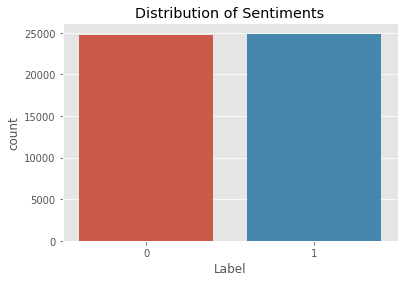

In [46]:
sns.countplot(x='Label', data=df)
plt.title("Distribution of Sentiments");

In [47]:
df.groupby('Label').count()['Review']

Label
0    24696
1    24884
Name: Review, dtype: int64

From the two cells above, we can clearly see that the number of movies with positive reviews is slightly larger than the number of movies with negative reviews.

### Number of words

Now, let's explore how the distribution of the number of words in both negative and positive reviews. We will first see the distributions of the reviews without removing stop words, then we will see the distributions of the reviews after the removal stop words.

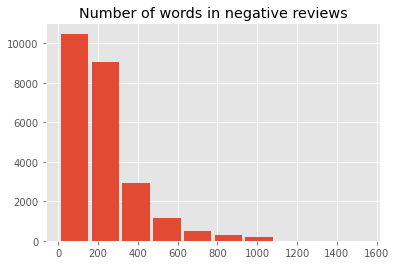

In [48]:
# Let's start with negative reviews without removing stop words.
plt.hist(df[df["Label"] == 0]["Word_count"], rwidth=0.9);
plt.title("Number of words in negative reviews")
plt.show()

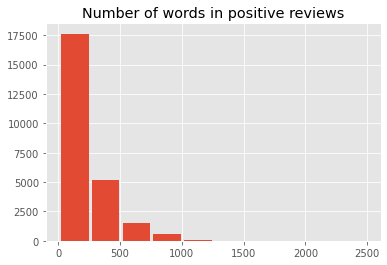

In [49]:
# Let's start with positive reviews without removing stop words.
plt.hist(df[df["Label"] == 1]["Word_count"], rwidth=0.9);
plt.title("Number of words in positive reviews")
plt.show()

In [50]:
# Let's see the mean of word counts for each label
df.groupby('Label').mean()["Word_count"]

Label
0    234.090298
1    237.157370
Name: Word_count, dtype: float64

Before removing stop words, we can clearly see that in average, positive reviews contains slightly more words then negative ones. However, from the histograms above, we can see that negative reviews tend to be longer.

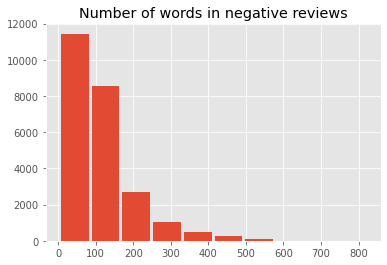

In [51]:
# Let's start with negative reviews without removing stop words.
plt.hist(df[df["Label"] == 0]["Word_count_no_stop_words"], rwidth=0.9);
plt.title("Number of words in negative reviews")
plt.show()

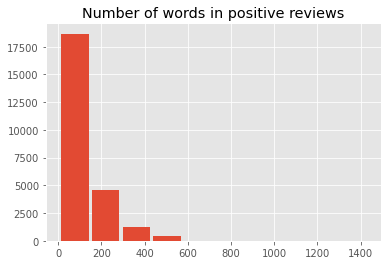

In [52]:
# Let's start with positive reviews without removing stop words.
plt.hist(df[df["Label"] == 1]["Word_count_no_stop_words"], rwidth=0.9);
plt.title("Number of words in positive reviews")
plt.show()

### Commun words in positive and negative reviews

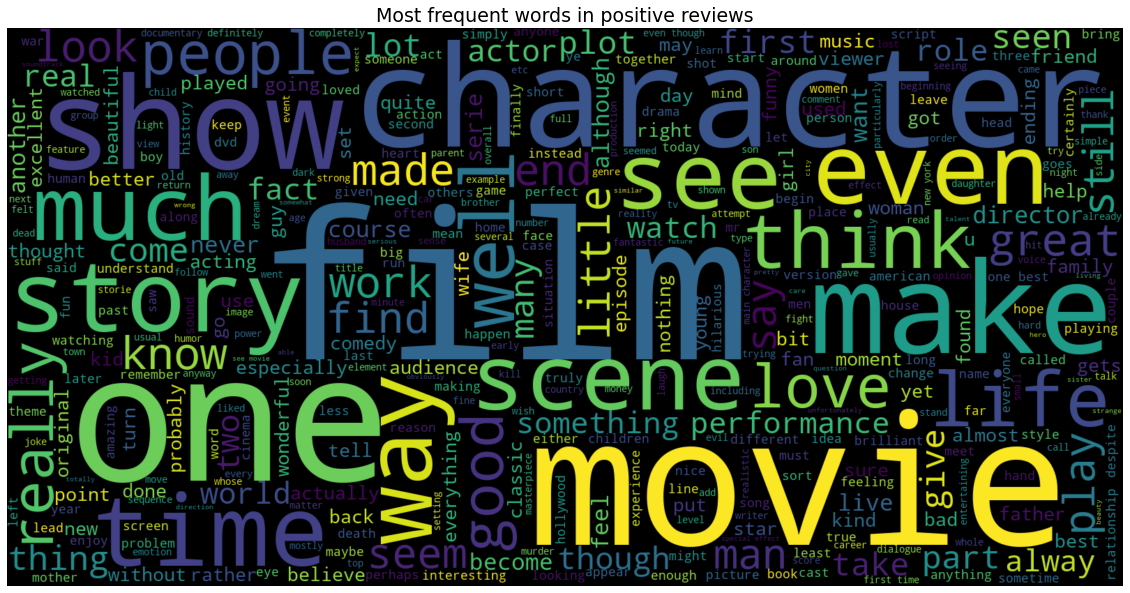

In [53]:
# We will build a word cloud for one of them.
# For reference, I used this link: https://www.geeksforgeeks.org/generating-word-cloud-python/ 
# Let's start with positive reviews.
text = ' '.join([word for word in df[df["Label"] == 1]["Review_no_stop_words"]])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=400, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

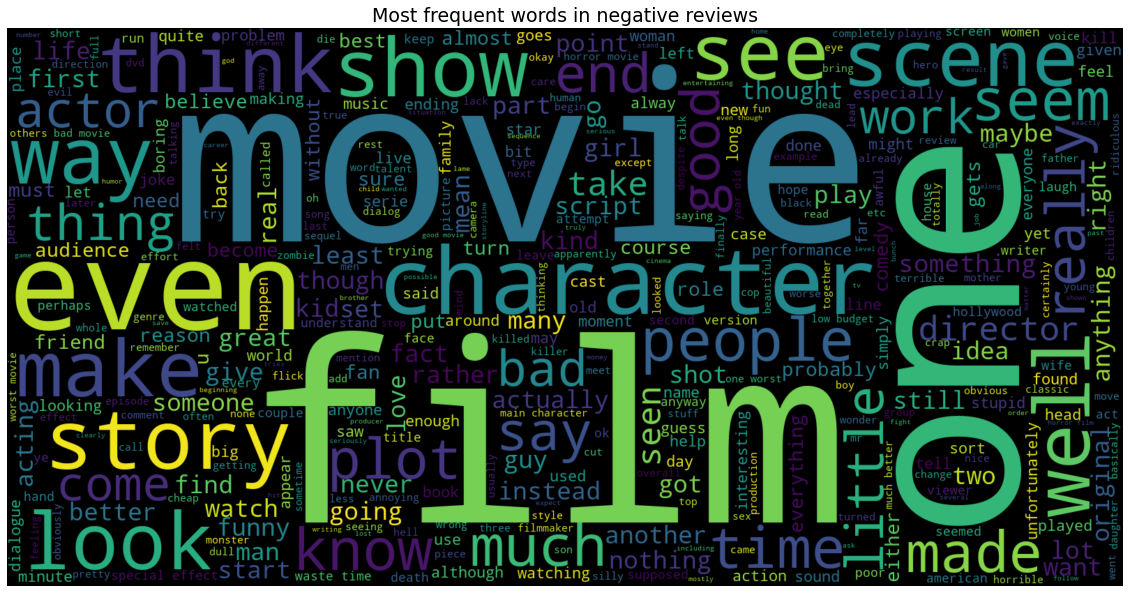

In [54]:
# Let's build one  with negative reviews.
text = ' '.join([word for word in df[df["Label"] == 0]["Review_no_stop_words"]])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=400, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

In [55]:
# Now let's see the most words in each review.
# We start with positive reviews.
df_pos = df[df["Label"] == 1]['Review_no_stop_words']
count_pos = collections.Counter()
for text in df_pos.values:
    for word in text.split():
        count_pos[word] +=1

In [56]:
pos_words = pd.DataFrame(count_pos.most_common(20))
pos_words.columns = ['Word', 'Count']
pos_words.head()

,Word,Count
0,film,41950
1,movie,37650
2,one,27202
3,like,17646
4,good,14961


Text(0.5, 0, 'Count')

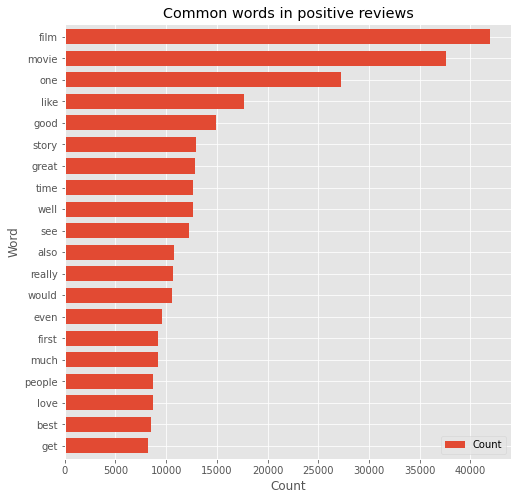

In [57]:
df_sorted = pos_words.sort_values('Count')
df_sorted.plot.barh(x="Word", y="Count", width=0.7, figsize=(8,8), title="Common words in positive reviews")
plt.ylabel('Word') 
plt.xlabel('Count') 

In [58]:
# Now let's see the most words in each review.
# We start with positive reviews.
df_neg = df[df["Label"] == 0]['Review_no_stop_words']
count_neg = collections.Counter()
for text in df_neg.values:
    for word in text.split():
        count_neg[word] +=1
count_neg.most_common(20)

[('movie', 49584),
 ('film', 37163),
 ('one', 25983),
 ('like', 22185),
 ('even', 15083),
 ('good', 14568),
 ('bad', 14548),
 ('would', 13851),
 ('really', 12216),
 ('time', 12201),
 ('see', 10595),
 ('story', 10064),
 ('get', 10015),
 ('much', 9972),
 ('people', 9333),
 ('make', 9257),
 ('could', 9183),
 ('made', 8705),
 ('well', 8420),
 ('movies', 8244)]

In [59]:
neg_words = pd.DataFrame(count_neg.most_common(20))
neg_words.columns = ['Word', 'Count']
neg_words.head()

,Word,Count
0,movie,49584
1,film,37163
2,one,25983
3,like,22185
4,even,15083


Text(0.5, 0, 'Count')

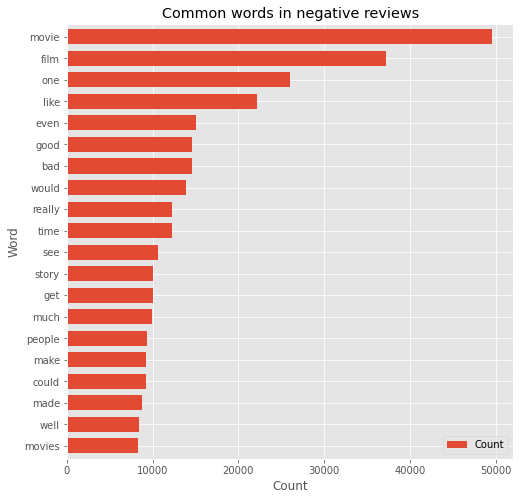

In [60]:
df_sorted = neg_words.sort_values('Count')
df_sorted.plot.barh(x="Word", y="Count", width=0.7, figsize=(8,8), title="Common words in negative reviews")
plt.ylabel('Word') 
plt.xlabel('Count')

From the word clouds and the two plots above, we notice that the words 'movie', 'film', 'one', and 'like' are commun in both reviews (they are the most commun ones actually), we do have other commun words between both reviews. However, positive reviews have a high count of the following words: 'great', 'love', 'best', and negative reviews, on the other hand, have a high count of 'bad'.

# Predictive modeling

After going through EDA, It's time to dig into predictive modeling. In this section, we will focus on building some models and compare between them, all the models that we've tried (as well as the intuition around them) are documented below.

In [61]:
# Let's get the data that we will be working with.
X = df['Review_no_stop_words']
Y = df['Label']

In [62]:
X.head()

0    absolutely terrible movie lured christopher wa...
1    known fall asleep films usually due combinatio...
2    mann photographs alberta rocky mountains super...
3    kind film snowy sunday afternoon rest world go...
4    others mentioned women go nude film mostly abs...
Name: Review_no_stop_words, dtype: object

In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# Transforms text to feature vectors that can be used as input to estimator.
V = TfidfVectorizer()
X = V.fit_transform(X)

In [93]:
# Let's split our data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [94]:
print("With stop words ----------------------")
print("The size of x_train: ", (x_train.shape))
print("The size of yx_train: ", (y_train.shape))
print("The size of x_test: ", (x_test.shape))
print("The size of yx_test: ", (y_test.shape))


With stop words ----------------------
The size of x_train:  (34706, 103707)
The size of yx_train:  (34706,)
The size of x_test:  (14874, 103707)
The size of yx_test:  (14874,)


### LogisticRegression

Can logistic regression be used for binary classification?
Logistic Regression is a “Supervised machine learning” algorithm that can be used to model the probability of a certain class or event. It is used when the data is linearly separable and the outcome is binary or dichotomous in nature. That means Logistic regression is usually used for Binary classification problems.

For reference: [click here](https://www.analyticsvidhya.com/blog/2021/07/an-introduction-to-logistic-regression/)

In [66]:
# Let's train our LogisticRegression model!
l = LogisticRegression()
l.fit(x_train, y_train)
l_pred = l.predict(x_test)
l_acc = accuracy_score(l_pred, y_test)
print("The accuracy is: {:.2f}%".format(l_acc*100))

The accuracy is: 89.63%


In [67]:
print("Confusion matrix:\n")
print(confusion_matrix(y_test, l_pred))

Confusion matrix:

[[6548  854]
 [ 688 6784]]




*   6548 positive reviews data points were correctly classified by the model as positive reviews.
*   6784 negative reviews data points were correctly classified by the model as negative reviews.


*   688 positive reviews were incorrectly classified as negative reviews.
*   854 positive reviews were incorrectly classified as negative reviews.

In [68]:
print("Classification report:\n")
print(classification_report(y_test, l_pred))

Classification report:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7402
           1       0.89      0.91      0.90      7472

    accuracy                           0.90     14874
   macro avg       0.90      0.90      0.90     14874
weighted avg       0.90      0.90      0.90     14874



### Gaussian classifier

In [69]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_pred = mnb.predict(x_test)
mnb_acc = accuracy_score(mnb_pred, y_test)
print("The accuracy is: {:.2f}%".format(mnb_acc*100))

The accuracy is: 86.80%


In [74]:
# Let's see the confusion matrix so we can compare the actual target values with those predicted by our model.
print("Confusion matrix:\n")
print(confusion_matrix(y_test, mnb_pred))

Confusion matrix:

[[6509  893]
 [1071 6401]]


*   6509 positive reviews data points were correctly classified by the model as positive reviews.
*   6509 negative reviews data points were correctly classified by the model as negative reviews.


*   1071 positive reviews were incorrectly classified as negative reviews.
*   893 positive reviews were incorrectly classified as negative reviews.

In [75]:
print("Classification report:\n")
print(classification_report(y_test, mnb_pred))

Classification report:

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      7402
           1       0.88      0.86      0.87      7472

    accuracy                           0.87     14874
   macro avg       0.87      0.87      0.87     14874
weighted avg       0.87      0.87      0.87     14874



According to the results above, we can say that the Logistic regression model performed better than Gaussian classifier.

### LinearSVC

In [76]:
svc = LinearSVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("The accuracy is: {:.2f}%".format(svc_acc*100))

The accuracy is: 89.67%


In [77]:
print("Confusion matrix:\n")
print(confusion_matrix(y_test, svc_pred))

Confusion matrix:

[[6579  823]
 [ 714 6758]]


*   6579 positive reviews data points were correctly classified by the model as positive reviews.
*   6758 negative reviews data points were correctly classified by the model as negative reviews.


*   714 positive reviews were incorrectly classified as negative reviews.
*   823 positive reviews were incorrectly classified as negative reviews.

In [78]:
print("Classification report:\n")
print(classification_report(y_test, svc_pred))

Classification report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7402
           1       0.89      0.90      0.90      7472

    accuracy                           0.90     14874
   macro avg       0.90      0.90      0.90     14874
weighted avg       0.90      0.90      0.90     14874



According to the results above, we can say that the LinearSVC model performed better than both Logistic regression and Gaussian classifier.

### Neural Network

In [80]:
# Our neural network will be composed of three layers: "input layer", "hidden layer" and "output layer".
# For reference: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [81]:
# Let's compile the model, this is our first attempt
# The hyperparameters: rmsprop as an optimizer, binary_crossentropy as a loss function, and the accuracy as a metric to measure performance.
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [95]:
x_train = x_train[:2000]
y_train = y_train[:2000]
x_test = x_test[:500]
y_test = y_test[:500]

In [96]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (2000, 103707)
Size of y_train:  (2000,)
Size of x_test:  (500, 103707)
Size of y_test:  (500,)


In [97]:
x_train = x_train.toarray()
x_test = x_test.toarray()

In [85]:
history = model.fit(x_train, y_train, batch_size=10, epochs=15)

Epoch 1/15
200/200 [==============================] - 4s 17ms/step - loss: 0.6601 - accuracy: 0.7570
Epoch 2/15
200/200 [==============================] - 7s 33ms/step - loss: 0.4574 - accuracy: 0.9325
Epoch 3/15
200/200 [==============================] - 6s 31ms/step - loss: 0.2283 - accuracy: 0.9620
Epoch 4/15
200/200 [==============================] - 4s 22ms/step - loss: 0.1056 - accuracy: 0.9785
Epoch 5/15
200/200 [==============================] - 4s 18ms/step - loss: 0.0528 - accuracy: 0.9885
Epoch 6/15
200/200 [==============================] - 4s 22ms/step - loss: 0.0287 - accuracy: 0.9925
Epoch 7/15
200/200 [==============================] - 3s 17ms/step - loss: 0.0165 - accuracy: 0.9950
Epoch 8/15
200/200 [==============================] - 3s 16ms/step - loss: 0.0093 - accuracy: 0.9985
Epoch 9/15
200/200 [==============================] - 3s 16ms/step - loss: 0.0057 - accuracy: 0.9985
Epoch 10/15
200/200 [==============================] - 3s 16ms/step - loss: 0.0033 - accura

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1659328   
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,659,473
Trainable params: 1,659,473
Non-trainable params: 0
_________________________________________________________________


In [98]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('The test loss:', test_loss)
print('The test accuracy:', test_acc)

16/16 [==============================] - 0s 7ms/step - loss: 0.7329 - accuracy: 0.8340
The test loss: 0.7329277992248535
The test accuracy: 0.8339999914169312


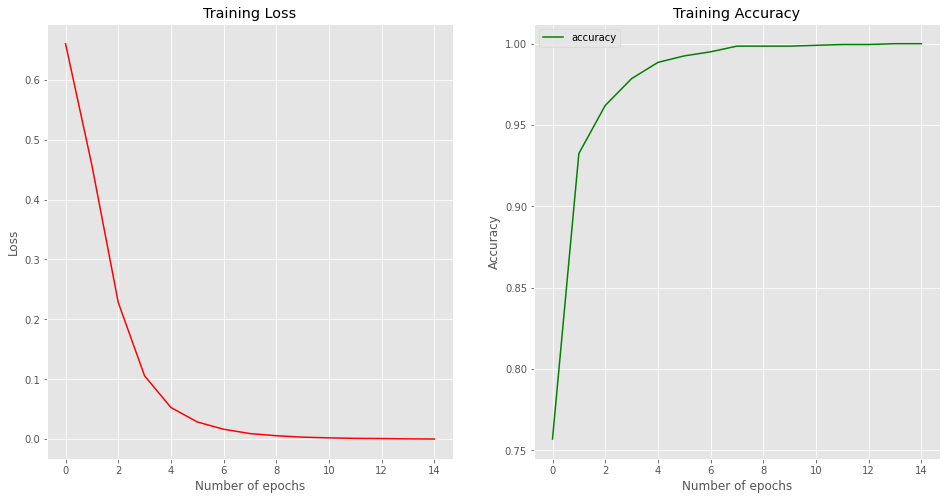

In [99]:
# For reference: https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r', label='loss')
plt.title('Training Loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='g', label='accuracy')
plt.title('Training Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [100]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [101]:
# For the second attemp.
# The hyperparameters: adam as an optimizer, binary_crossentropy as a loss function, and the accuracy as a metric to measure performance.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
history = model.fit(x_train, y_train, batch_size=10, epochs=15)

Epoch 1/15
200/200 [==============================] - 3s 12ms/step - loss: 0.6468 - accuracy: 0.7230
Epoch 2/15
200/200 [==============================] - 2s 12ms/step - loss: 0.2690 - accuracy: 0.9730
Epoch 3/15
200/200 [==============================] - 2s 11ms/step - loss: 0.0475 - accuracy: 0.9965
Epoch 4/15
200/200 [==============================] - 2s 11ms/step - loss: 0.0138 - accuracy: 0.9990
Epoch 5/15
200/200 [==============================] - 2s 11ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 6/15
200/200 [==============================] - 2s 11ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 7/15
200/200 [==============================] - 2s 11ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 8/15
200/200 [==============================] - 2s 11ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 9/15
200/200 [==============================] - 2s 11ms/step - loss: 7.7324e-04 - accuracy: 1.0000
Epoch 10/15
200/200 [==============================] - 2s 11ms/step - loss: 5.2246e-04 

In [103]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                1659328   
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,659,473
Trainable params: 1,659,473
Non-trainable params: 0
_________________________________________________________________


In [105]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('The test loss:', test_loss)
print('The test accuracy:', test_acc)

16/16 [==============================] - 0s 13ms/step - loss: 0.4543 - accuracy: 0.8300
The test loss: 0.4542846083641052
The test accuracy: 0.8299999833106995


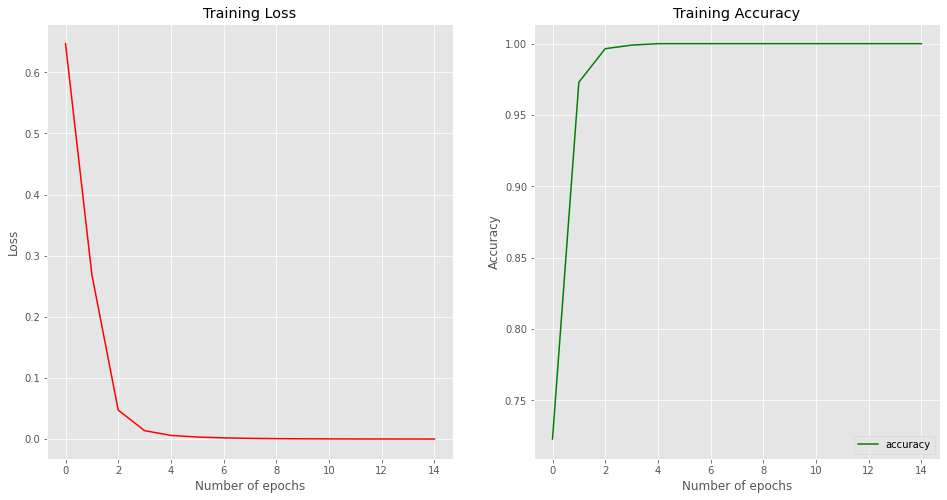

In [106]:
# For reference: https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r', label='loss')
plt.title('Training Loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='g', label='accuracy')
plt.title('Training Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()